In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
RANDOM_SEED = 42

In [99]:
train = pd.read_csv("/kaggle/input/vk-test-spam/train_spam.csv")
test = pd.read_csv("/kaggle/input/vk-test-spam/test_spam.csv")

In [100]:
train

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


Посмотрим на уникальные значения и данные детальнее


In [101]:
train.text_type.unique()

array(['ham', 'spam'], dtype=object)

In [102]:
train.iloc[16274].text

'dirty pictureblyk on aircel thanks you for being a valued member heres an exclusive animated trailer for the dirty picture the insider scoop saysvidya balans sexy avatar itsy bitsy clothes cleavageshowing blouses and raunchy dance numbers in the dirty picture are receiving jawdropping reactions fans and trade pundits say the masala movie is expected to beat the musical treat rockstar the funfilled desi boyz and the action thriller don 2 dont miss it!'

Прикольно, ну штош, для начала заменим target на чиселки, будем предсказывать спам, поэтому метка спама - 1, хама - 0

In [103]:
train.text_type = train.text_type.map({'ham':0 , 'spam':1})

In [104]:
train.rename(columns={'text_type':'target'}, inplace=True)

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  16278 non-null  int64 
 1   text    16278 non-null  object
dtypes: int64(1), object(1)
memory usage: 254.5+ KB


In [106]:
train

,target,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...
...,...,...
16273,1,if you are interested in binary options tradin...
16274,1,dirty pictureblyk on aircel thanks you for bei...
16275,0,or you could do this g on mon 1635465 sep 1635...
16276,0,insta reels par 80 गंद bhara pada hai 👀 kuch b...


### Мини EDA

Посмотрим есть ли дисбаланс

In [107]:
import seaborn as sns

<Axes: xlabel='target', ylabel='count'>

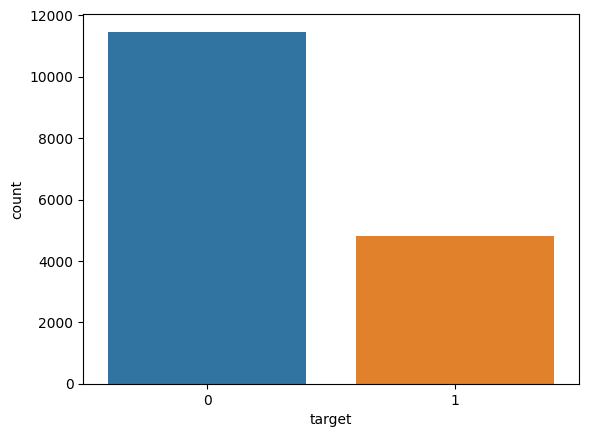

In [108]:
sns.countplot(x='target', data=train)

Опачки, дисбалансик.... 

Пока будем просто учитывать это при подсчете метрик, в конце попробуем решить проблемку

In [115]:
temp = train
temp['text_length'] = temp['text'].apply(lambda x: len(x.split()))

In [116]:
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

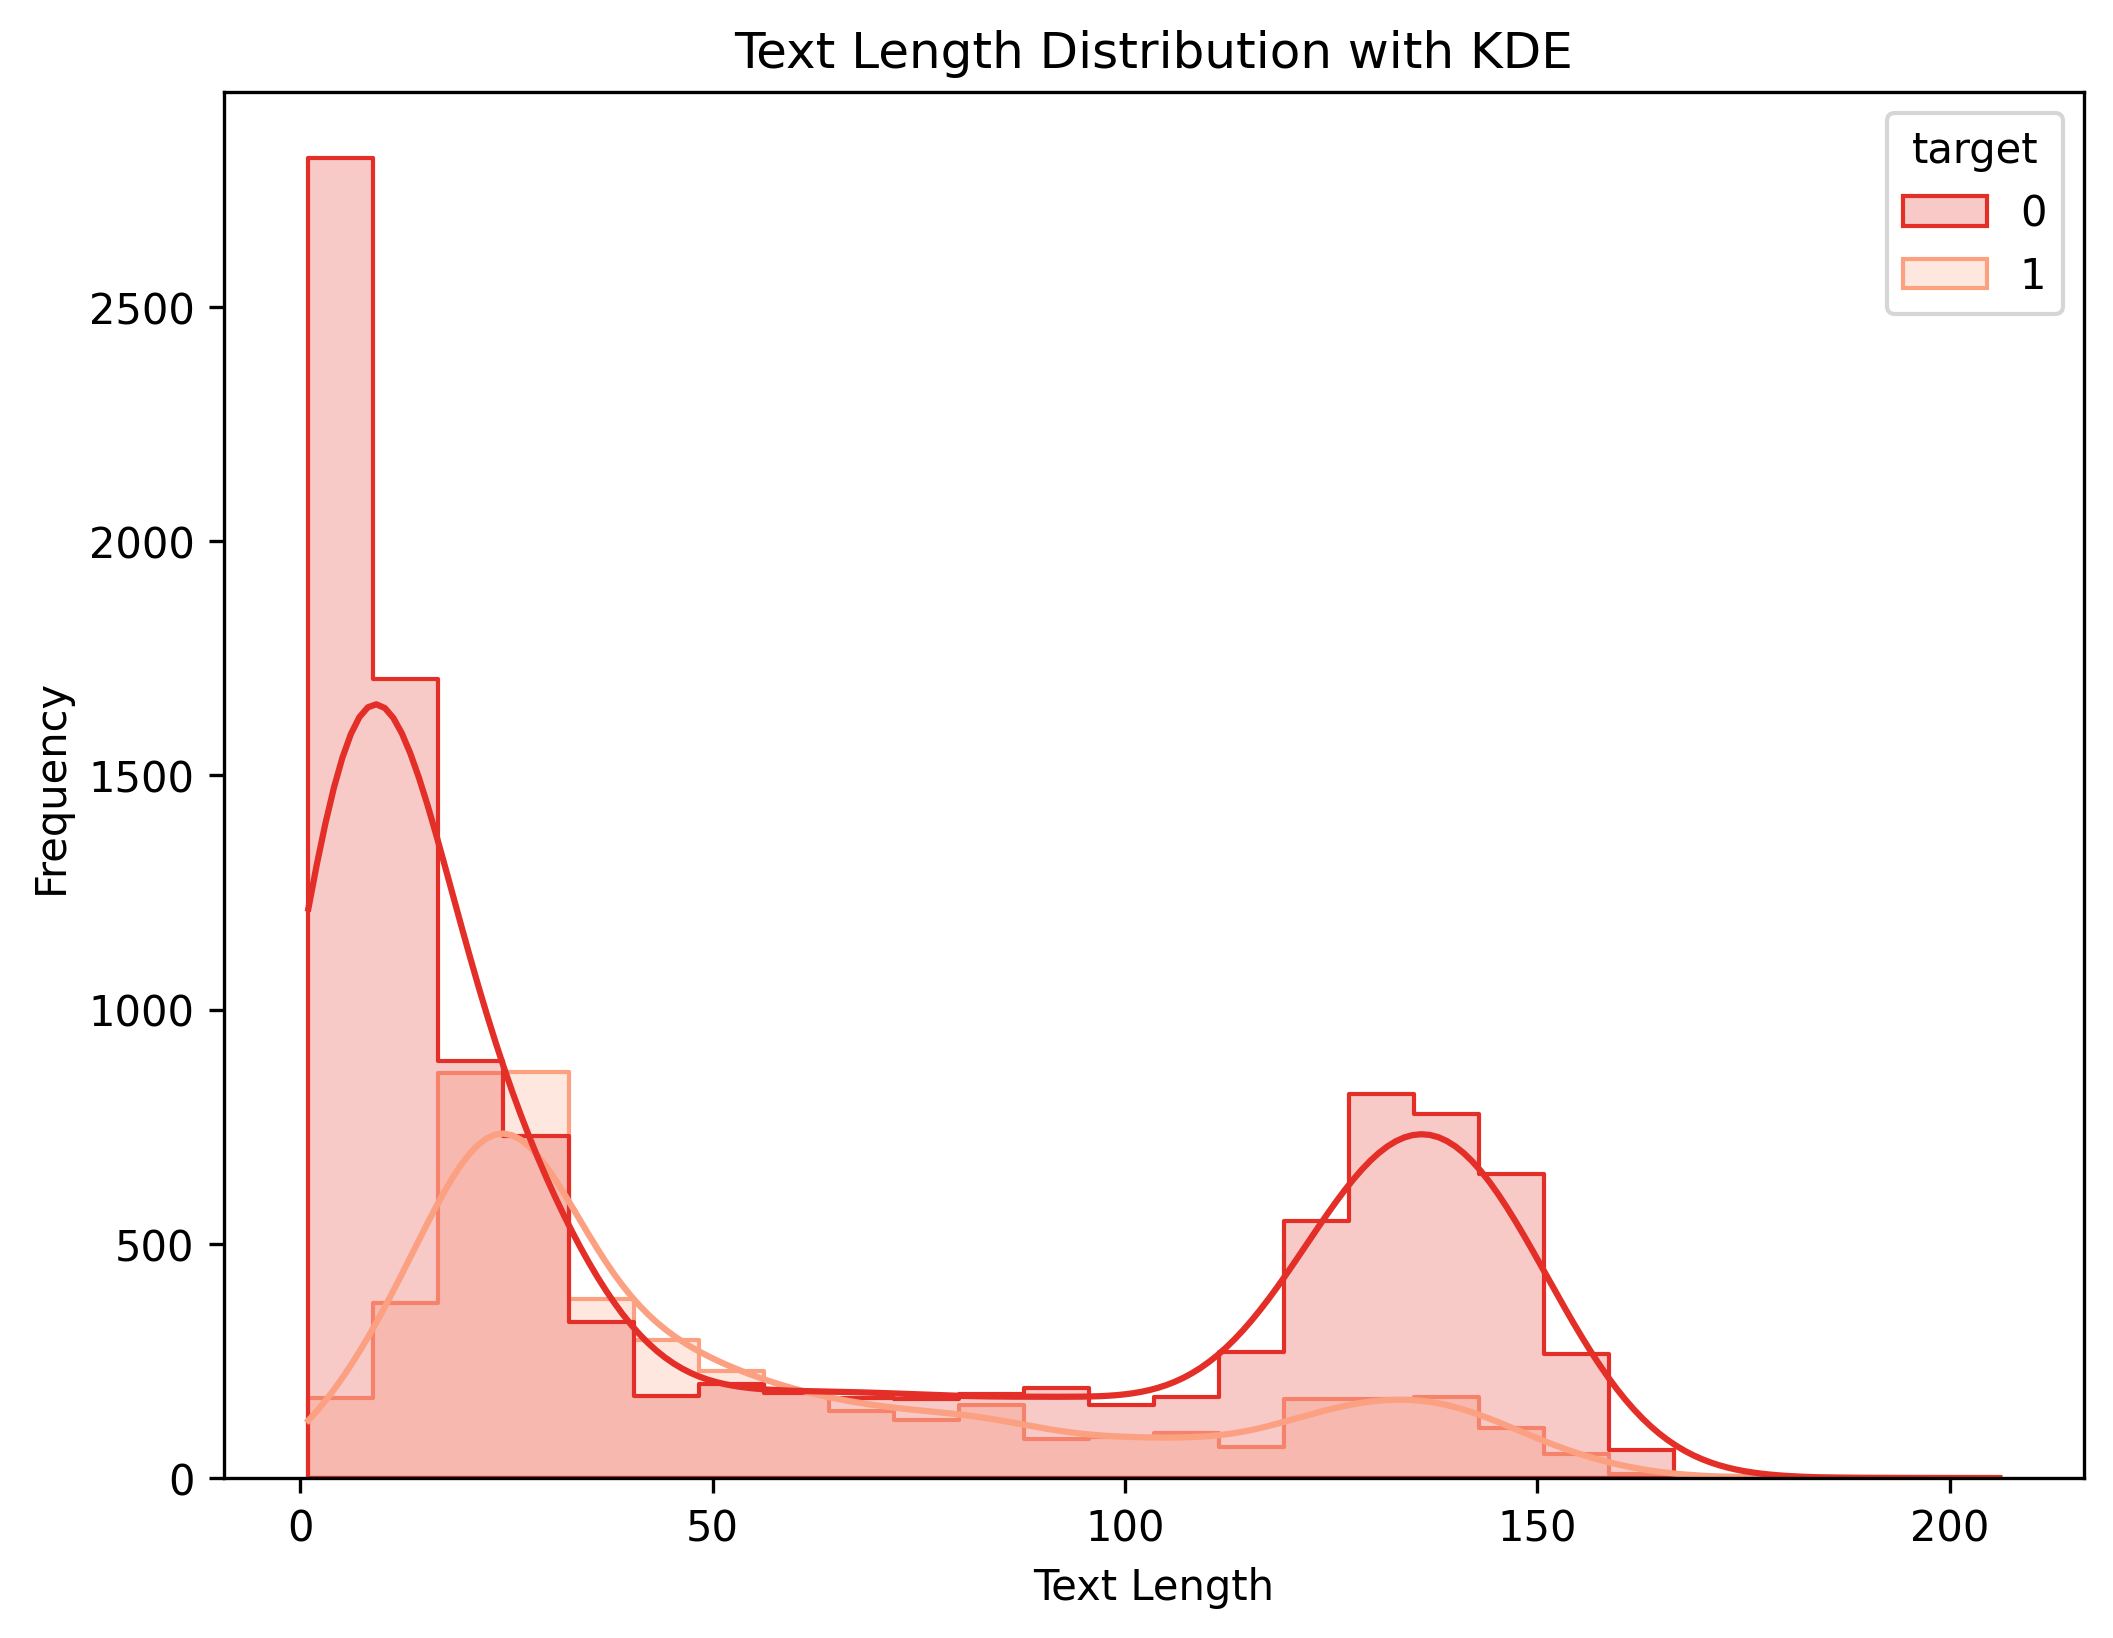

In [117]:
red_palette = sns.color_palette("Reds_r", 2)
plt.figure(figsize=(8, 6), dpi=300)
sns.set_palette(red_palette)
sns.histplot(data=temp, x='text_length', hue='target', kde=True, element='step')
plt.title('Text Length Distribution with KDE')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Train

Сама задача - классификация, но прежде чем перейти к ее решению, необходимо как-то заэнкодить текст

### Baseline

Бейзлайн решение - классика, tf-idf + NB. Затем попробую логрег и бустинг. Далее в бой пойдут нейросетевые решения, возьму мб претрейн берта

Прежде чем начать сделаю валидационную выборку

In [13]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=0.2, random_state=RANDOM_SEED)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop = stopwords.words()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
X_train, y_train = train.text, train.target 

In [16]:
X_val, y_val = val.text, val.target

При работе с векторизированными текстами, обычно полагают, что данные распределены по мультиномиальному закону распределения, поэтому используется MultinomialNB

In [17]:
from sklearn.naive_bayes import MultinomialNB

In [18]:
pipeline_nb = Pipeline(steps=[
    ('vct', TfidfVectorizer(stop_words=stop)),
    ('clf', MultinomialNB())
])


In [19]:
pipeline_nb.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

Pipeline(steps=[('vct',
                 TfidfVectorizer(stop_words=['إذ', 'إذا', 'إذما', 'إذن', 'أف',
                                             'أقل', 'أكثر', 'ألا', 'إلا',
                                             'التي', 'الذي', 'الذين', 'اللاتي',
                                             'اللائي', 'اللتان', 'اللتيا',
                                             'اللتين', 'اللذان', 'اللذين',
                                             'اللواتي', 'إلى', 'إليك', 'إليكم',
                                             'إليكما', 'إليكن', 'أم', 'أما',
                                             'أما', 'إما', 'أن', ...])),
                ('clf', MultinomialNB())])

Требуемая метрика ROC-AUC, ее и посчитаем на валидационном датасете

In [20]:
y_preds = pipeline_nb.predict_proba(X_val)

In [21]:
from sklearn.metrics import roc_auc_score

In [22]:
roc_auc_score(y_val, y_preds[:, 1])

0.9517285790976138

Ну а теперь самое смешное - побить этот бейзлайн

Для начала попробую подобрать n-граммы

In [23]:
pipeline_nb_2 = Pipeline(steps=[
    ('vct', TfidfVectorizer(analyzer="char", ngram_range=(1, 10))),
    ('clf', MultinomialNB())
])
pipeline_nb_2.fit(X_train, y_train)
y_preds = pipeline_nb_2.predict_proba(X_val)


In [24]:
roc_auc_score(y_val, y_preds[:, 1])

0.8107721409036766

Да, поскольку текст представляет собой какой-то структурированный набор, то выделение н-грамм показывает себя хуже, чем анализ слов. Вообще идея n-грамм как-то справляться с синтаксическими ошибками и заменой каких-то букв, видимо ошибок мало в тексте, попробуем потюнить классификатор

In [25]:
alpha = [0, 0.2, 0.4, 0.6, 0.8, 1.2, 1.4, 1.6, 1.8 ,2]

for a in alpha:
    temp = Pipeline(steps=[
    ('vct', TfidfVectorizer(stop_words=stop)),
    ('clf', MultinomialNB(alpha = a))
    ])
    temp.fit(X_train, y_train)
    y_preds = temp.predict_proba(X_val)
    score = roc_auc_score(y_val, y_preds[:, 1])
    print(f"{a=}, {score=}")


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=0, score=0.9455137583606549


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=0.2, score=0.9700656871577114


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=0.4, score=0.9646738566955512


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=0.6, score=0.9598566448631076


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=0.8, score=0.9555518435489037


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=1.2, score=0.9484541284297981


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=1.4, score=0.9456335665753512


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=1.6, score=0.943118976469206


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=1.8, score=0.9408089819296955


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

a=2, score=0.938716024579116


In [26]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import re

В тексте правда есть не только английский, но преимущественно все же он

In [27]:
stopwords = stopwords.words('english')
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    stems = [stemmer.stem(t) for t in filtered_tokens if t not in stopwords]

    return stems

In [28]:
alpha = np.linspace(0, 0.3, 10)

for a in alpha:
    temp = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', MultinomialNB(alpha = a, force_alpha=False))
    ])
    temp.fit(X_train, y_train)
    y_preds = temp.predict_proba(X_val)
    score = roc_auc_score(y_val, y_preds[:, 1])
    print(f"{a=}, {score=}")


/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


a=0.0, score=0.9421455347247983
a=0.03333333333333333, score=0.9705589744416822
a=0.06666666666666667, score=0.9707815412405219
a=0.1, score=0.9705474544210383
a=0.13333333333333333, score=0.9699456485426021
a=0.16666666666666666, score=0.9692355544701136
a=0.2, score=0.9684194762077014
a=0.23333333333333334, score=0.9675596218668424
a=0.26666666666666666, score=0.9666665898665291
a=0.3, score=0.9658698652387985


Выберем альфу равную 0.07 и посчитаем другие метрики

In [29]:
from sklearn.metrics import classification_report

pipeline_nb = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', MultinomialNB(alpha = 0.07, force_alpha=False))
    ])
pipeline_nb.fit(X_train, y_train)
y_preds = pipeline_nb.predict_proba(X_val)
roc_auc_score(y_val, y_preds[:, 1])

0.970754814792628

In [30]:
y_preds = pipeline_nb.predict(X_val)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2321
           1       0.87      0.81      0.84       935

    accuracy                           0.91      3256
   macro avg       0.90      0.88      0.89      3256
weighted avg       0.91      0.91      0.91      3256



Видно, что плохо распознаем 1й класс, теперь самое время вспомнить, что существует дисбаланс, так что попробую поработать с ним

In [31]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
x_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)

y_ros.value_counts()

target
0    9148
1    9148
Name: count, dtype: int64

In [32]:
x_ros = x_ros[:, 0]

In [33]:
pipeline_nb = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', MultinomialNB(alpha = 0.07, force_alpha=False))
    ])
pipeline_nb.fit(x_ros, y_ros)
y_preds = pipeline_nb.predict_proba(X_val)
roc_auc_score(y_val, y_preds[:, 1])

0.9692415448808485

In [34]:
y_preds = pipeline_nb.predict(X_val)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2321
           1       0.80      0.87      0.83       935

    accuracy                           0.90      3256
   macro avg       0.87      0.89      0.88      3256
weighted avg       0.90      0.90      0.90      3256



Хм-хм-хм интересно, а теперь попробую undersampling

In [35]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='majority')
x_rus, y_rus = undersampler.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
y_rus.value_counts()

target
0    3874
1    3874
Name: count, dtype: int64

In [36]:
x_rus = x_rus[:, 0]

In [37]:
pipeline_nb = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', MultinomialNB(alpha = 0.07, force_alpha=False))
    ])
pipeline_nb.fit(x_rus, y_rus)
y_preds = pipeline_nb.predict_proba(X_val)
roc_auc_score(y_val, y_preds[:, 1])

0.9686664654503061

In [38]:
y_preds = pipeline_nb.predict(X_val)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2321
           1       0.77      0.89      0.82       935

    accuracy                           0.89      3256
   macro avg       0.86      0.89      0.87      3256
weighted avg       0.90      0.89      0.89      3256



Ладно, зафиксируме, то что имеем на текущий момент:
Наивный байес + tf-idf выдает целевую метрику 0.9707

Попробуем поменять классификатор

### Boosting

In [39]:
from lightgbm import LGBMClassifier

In [40]:
pipeline_boosting = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', LGBMClassifier())
    ])
pipeline_boosting.fit(X_train, y_train)
y_preds = pipeline_boosting.predict_proba(X_val)
roc_auc_score(y_val, y_preds[:, 1])

[LightGBM] [Info] Number of positive: 3874, number of negative: 9148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84050
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 2417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297497 -> initscore=-0.859248
[LightGBM] [Info] Start training from score -0.859248


0.9690609109571525

In [41]:
y_preds = pipeline_boosting.predict_proba(X_train)
roc_auc_score(y_train, y_preds[:, 1])

0.9860988711080271

Из коробки результат не очень, нужно покрутить параметры. Подключу оптюну

In [42]:
import optuna

In [43]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 5, 50),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'random_state': 42
    }
    
    pipeline_boosting = Pipeline(steps=[
        ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
        ('clf', LGBMClassifier(**params))
    ])
    pipeline_boosting.fit(X_train, y_train)
    preds = pipeline_boosting.predict_proba(X_val)[:, 1]
    auc_valid = roc_auc_score(y_val, preds)
    
    return auc_valid

In [44]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2024-05-03 18:24:33,398] A new study created in memory with name: no-name-a9dff2b1-134a-4740-a335-d6c56442ce75


[LightGBM] [Info] Number of positive: 3874, number of negative: 9148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84050
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 2417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297497 -> initscore=-0.859248
[LightGBM] [Info] Start training from score -0.859248


[I 2024-05-03 18:25:03,063] Trial 0 finished with value: 0.9694627292772109 and parameters: {'learning_rate': 0.21233558878059616, 'num_leaves': 50, 'n_estimators': 163}. Best is trial 0 with value: 0.9694627292772109.


[LightGBM] [Info] Number of positive: 3874, number of negative: 9148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84050
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 2417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297497 -> initscore=-0.859248
[LightGBM] [Info] Start training from score -0.859248


[I 2024-05-03 18:25:31,568] Trial 1 finished with value: 0.9651735951910827 and parameters: {'learning_rate': 0.32719631404939803, 'num_leaves': 35, 'n_estimators': 214}. Best is trial 0 with value: 0.9694627292772109.


[LightGBM] [Info] Number of positive: 3874, number of negative: 9148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84050
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 2417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297497 -> initscore=-0.859248
[LightGBM] [Info] Start training from score -0.859248


[I 2024-05-03 18:25:57,904] Trial 2 finished with value: 0.9688014800922524 and parameters: {'learning_rate': 0.09326146243435623, 'num_leaves': 44, 'n_estimators': 78}. Best is trial 0 with value: 0.9694627292772109.


[LightGBM] [Info] Number of positive: 3874, number of negative: 9148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84050
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 2417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297497 -> initscore=-0.859248
[LightGBM] [Info] Start training from score -0.859248


[I 2024-05-03 18:26:23,733] Trial 3 finished with value: 0.9608471362380681 and parameters: {'learning_rate': 0.8623461644023122, 'num_leaves': 43, 'n_estimators': 73}. Best is trial 0 with value: 0.9694627292772109.


[LightGBM] [Info] Number of positive: 3874, number of negative: 9148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84050
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 2417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297497 -> initscore=-0.859248
[LightGBM] [Info] Start training from score -0.859248


[I 2024-05-03 18:26:47,816] Trial 4 finished with value: 0.898715056897382 and parameters: {'learning_rate': 0.02297370718456907, 'num_leaves': 8, 'n_estimators': 83}. Best is trial 0 with value: 0.9694627292772109.


In [45]:
best_params = study.best_params
best_params

{'learning_rate': 0.21233558878059616, 'num_leaves': 50, 'n_estimators': 163}

In [46]:
# Эти параметры выдала оптюна при одном из запусков, возможно после множества перезапусков они не соответствуют
# тому, что может быть выше в логах оптюны

params_saved = {'learning_rate': 0.4884732120734771, 'num_leaves': 32, 'n_estimators': 66}

In [47]:
pipeline_boosting = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', LGBMClassifier(**params_saved))
    ])
pipeline_boosting.fit(X_train, y_train)
y_preds = pipeline_boosting.predict_proba(X_val)
roc_auc_score(y_val, y_preds[:, 1])

[LightGBM] [Info] Number of positive: 3874, number of negative: 9148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84050
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 2417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297497 -> initscore=-0.859248
[LightGBM] [Info] Start training from score -0.859248


0.9734028067378296

Можно покрутить еще, но уже побил прошлый бейзлайн

In [48]:
pipeline_boosting = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', LGBMClassifier(**params_saved))
    ])
pipeline_boosting.fit(x_ros, y_ros)
y_preds = pipeline_boosting.predict_proba(X_val)
roc_auc_score(y_val, y_preds[:, 1])

[LightGBM] [Info] Number of positive: 9148, number of negative: 9148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106013
[LightGBM] [Info] Number of data points in the train set: 18296, number of used features: 2967
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


0.9709736951848618

In [49]:
pipeline_boosting = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', LGBMClassifier(**params_saved))
    ])
pipeline_boosting.fit(x_rus, y_rus)
y_preds = pipeline_boosting.predict_proba(X_val)
roc_auc_score(y_val, y_preds[:, 1])

[LightGBM] [Info] Number of positive: 3874, number of negative: 3874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47599
[LightGBM] [Info] Number of data points in the train set: 7748, number of used features: 1674
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


0.9628101477557848

### Нейросетевое решение

Как известно, tf-idf не учитывает семантику слов в предложении, то попробуем что-нибудь сложнее. 
Одним из популярных решений является использование претрейна берта и просто линейного слоя для классификации, 
попробую реализовать это решение. 

In [50]:
from sklearn.model_selection import StratifiedKFold

In [51]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

from tqdm.auto import tqdm
from bs4 import BeautifulSoup


from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import f1_score, roc_auc_score

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [52]:
device

device(type='cuda')

In [53]:
def text_cleaning(text):
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\d\s]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = re.sub(r"RT ", " ", text) #Remove RT for Re-tweets
    text = re.sub(r"[0-9]", " ", text) #Remove Numbers
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text

In [54]:
X_train_f = X_train.apply(text_cleaning)

/tmp/ipykernel_34/3596941346.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml') #Removes HTML tags


In [55]:
X_train_f

1157                           going to take your babe out
3474     ken attached is a correction to pages       an...
4084                            except android is a cucked
1383     stop been afraid stop the procrastination make...
14626    on aug         bort paul wrote if your sendmai...
                               ...                        
13418    transition to research group an update molly j...
5390     avistar users and allocated charges avistar ha...
860      account for sale total mythics    account leve...
15795    a a program question gwyn just because the a a...
7270     in my dream u me went   a wishwell i bent down...
Name: text, Length: 13022, dtype: object

In [56]:
X_val_f = X_val.apply(text_cleaning)

/tmp/ipykernel_34/3596941346.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml') #Removes HTML tags


In [67]:
params = {
    'checkpoint': 'bert-base-uncased',
    'output_logits': 768,
    'max_len': 128,
    'num_folds': 5,
    'batch_size': 32,
    'dropout': 0.1,
    'num_workers': 2,
    'epochs': 10,
    'lr': 2e-5,
    'scheduler_name': 'OneCycleLR',
    'max_lr': 5e-5,                 # OneCycleLR
    'pct_start': 0.1,               # OneCycleLR
    'anneal_strategy': 'cos',       # OneCycleLR
    'div_factor': 1e3,              # OneCycleLR
    'final_div_factor': 1e3,        # OneCycleLR
}

In [68]:
class BERTDataset:
  def __init__(self, texts, labels, max_len=params['max_len'], checkpoint=params['checkpoint']):
    self.texts = texts
    self.labels = labels
    self.max_len = max_len
    self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    self.num_examples = len(self.texts)

  def __len__(self):
    return self.num_examples

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]
    tokenized_text = self.tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=self.max_len,
    )
    ids = tokenized_text['input_ids']
    mask = tokenized_text['attention_mask']
    token_type_ids = tokenized_text['token_type_ids']

    return {'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(label, dtype=torch.float)}

In [69]:
def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=scheduler_params['T_0'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    elif scheduler_params['scheduler_name'] == 'OneCycleLR':
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scheduler_params['max_lr'],
            steps_per_epoch=int(X_train_f.shape[0] / params['batch_size']) + 1,
            epochs=scheduler_params['epochs'],
            pct_start=scheduler_params['pct_start'],
            anneal_strategy=scheduler_params['anneal_strategy'],
            div_factor=scheduler_params['div_factor'],
            final_div_factor=scheduler_params['final_div_factor'],
        )
    return scheduler

In [70]:
class SpamDetector(nn.Module):
  def __init__(self, checkpoint=params['checkpoint'], params=params):
    super(SpamDetector, self).__init__()
    self.bert = AutoModel.from_pretrained(checkpoint, return_dict=False)
    self.dropout = nn.Dropout(params['dropout'])
    self.classifier = nn.Linear(params['output_logits'], 1)

  def forward(self, input_ids, token_type_ids, attention_mask):
    _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    return logits

In [71]:
def usr_roc_score(output, target):
    try:
        y_pred = torch.sigmoid(output).cpu()
        y_pred = y_pred.detach().numpy()
        target = target.cpu()
        return roc_auc_score(target, y_pred)
    except:
        return 0.5

In [72]:
def train(model, device, train_dataset, valid_dataset, params=params, epochs=params['epochs'], scheduler=params['scheduler_name']):
  model.to(device)
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
  ]
  optimizer = optim.AdamW(optimizer_grouped_parameters, lr=params['lr'])
  
  if scheduler is not None:
      scheduler = get_scheduler(optimizer)
  
  criterion = nn.BCEWithLogitsLoss()

  for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_f1 = 0
    train_roc = 0
    stream_1 = tqdm(train_dataset)
    stream_1.set_description('Training')
    for batch in stream_1:
      optimizer.zero_grad()
      ids = batch['ids'].to(device)
      mask = batch['mask'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      target = batch['target'].to(device)
      logits = model(ids, token_type_ids, mask)
      loss = criterion(logits, target.view(-1, 1))
      roc_score = usr_roc_score(logits, target)
      loss.backward()
      optimizer.step()
      if scheduler is not None:
        scheduler.step()
      train_loss += loss.item() * batch['ids'].size(0)
      train_roc += roc_score
      stream_1.update(1)
    
    train_loss/= len(train_dataset)
    train_f1 /= len(train_dataset)
    train_roc /= len(train_dataset)

    model.eval()
    valid_loss = 0
    valid_roc = 0
    stream_2 = tqdm(valid_dataset)
    stream_2.set_description('Validating')
    for batch in stream_2:
      ids = batch['ids'].to(device)
      mask = batch['mask'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      target = batch['target'].to(device)
      logits = model(ids, token_type_ids, mask)
      loss = criterion(logits, target.view(-1, 1))
      roc_score = usr_roc_score(logits, target)
      valid_loss += loss.item() * batch['ids'].size(0)
      valid_roc += roc_score
      stream_2.update(1)

    valid_loss /= len(valid_dataset)
    valid_roc /= len(valid_dataset)

    print(f"Epoch: {epoch+1:02}/{epochs:02}. Train Loss: {train_loss:.3f}. Validation Loss: {valid_loss:.3f}")
    print(f"Epoch: {epoch+1:02}/{epochs:02}. Train ROC: {train_roc:.3f}. Validation ROC: {valid_roc:.3f}")

In [73]:
train_dataset = BERTDataset(
    X_train_f.values,
    y_train.values
)

valid_dataset = BERTDataset(
    X_val_f.values,
    y_val.values
)

train_dataloader = DataLoader(
    train_dataset, batch_size=params['batch_size'], shuffle=True,
    num_workers=params['num_workers'], pin_memory=True
)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=params['batch_size'], shuffle=False,
    num_workers=params['num_workers'], pin_memory=True
)

In [74]:
model = SpamDetector()

In [75]:
train(model, device, train_dataloader, valid_dataloader)

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 01/10. Train Loss: 17.611. Validation Loss: 15.592
Epoch: 01/10. Train ROC: 0.709. Validation ROC: 0.886


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67ad51caf0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67ad51caf0>
Exception ignored in: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67ad51caf0>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/opt/conda/l

Epoch: 02/10. Train Loss: 18.607. Validation Loss: 19.421
Epoch: 02/10. Train ROC: 0.586. Validation ROC: 0.770


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 03/10. Train Loss: 19.574. Validation Loss: 19.339
Epoch: 03/10. Train ROC: 0.516. Validation ROC: 0.861


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 04/10. Train Loss: 19.535. Validation Loss: 19.188
Epoch: 04/10. Train ROC: 0.513. Validation ROC: 0.634


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 05/10. Train Loss: 19.593. Validation Loss: 19.149
Epoch: 05/10. Train ROC: 0.502. Validation ROC: 0.780


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 06/10. Train Loss: 19.550. Validation Loss: 19.112
Epoch: 06/10. Train ROC: 0.506. Validation ROC: 0.606


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 07/10. Train Loss: 17.209. Validation Loss: 15.136
Epoch: 07/10. Train ROC: 0.654. Validation ROC: 0.863


  0%|          | 0/407 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67ad51caf0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67ad51caf0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.10/multiprocessing/process.

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 08/10. Train Loss: 12.615. Validation Loss: 9.228
Epoch: 08/10. Train ROC: 0.876. Validation ROC: 0.940


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 09/10. Train Loss: 8.693. Validation Loss: 9.255
Epoch: 09/10. Train ROC: 0.947. Validation ROC: 0.923


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch: 10/10. Train Loss: 7.569. Validation Loss: 9.337
Epoch: 10/10. Train ROC: 0.955. Validation ROC: 0.932


В целом данное решение можно дотюнить сильнее, у меня к сожалению уже кончается время, поэтому сохраним то, что выдало решение с lgbm + tf-idf

In [76]:
pipeline_boosting = Pipeline(steps=[
    ('vct', TfidfVectorizer(tokenizer=tokenize_and_stem, token_pattern=None)),
    ('clf', LGBMClassifier(**params_saved))
    ])
pipeline_boosting.fit(X_train, y_train)
y_preds = pipeline_boosting.predict_proba(X_val)
roc_auc_score(y_val, y_preds[:, 1])

[LightGBM] [Info] Number of positive: 3874, number of negative: 9148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84050
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 2417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297497 -> initscore=-0.859248
[LightGBM] [Info] Start training from score -0.859248


0.9734028067378296

In [77]:
test

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


In [84]:
test.text

0       j jim whitehead ejw cse ucsc edu writes j you ...
1       original message from bitbitch magnesium net p...
2       java for managers vince durasoft who just taug...
3                    there is a youtuber name saiman says
4       underpriced issue with high return on equity t...
                              ...                        
4065    husband to wifetum meri zindagi hoorwifeor kya...
4066    baylor enron case study cindy yes i shall co a...
4067                             boring as compared to tp
4068    hellogorgeous hows u my fone was on charge lst...
4069    energy conference mark we are really swamped a...
Name: text, Length: 4070, dtype: object

In [87]:
y_preds = pipeline_boosting.predict_proba(test.text)[:, 1]

array([2.20135089e-02, 2.47372470e-04, 2.12199305e-05, 3.91646949e-06,
       1.50480575e-03])

In [91]:
y_preds

array([3.56811592e-03, 3.69599709e-02, 8.00213123e-06, ...,
       2.63903115e-01, 2.33816200e-04, 6.04288631e-07])

In [92]:
res = pd.DataFrame()

In [93]:
res['text'] = test.text
res['score'] = y_preds

In [96]:
res.to_csv('/kaggle/working/res.csv', index=False)

Из дополнительных улучшений, можно сильнее чистить текст - удалить смайлики, перевести курсив и стремные символы во что-то человеческое